

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

### Работу выполнил Кирилл Лаврентьев
Team на Kaggle: Кирилл\_Лаврентьев\_291408035

Score на Kaggle: 0.99468

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [1]:
# ignore deprication warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# standard python modules
import os, sys
import time


# standard ml modules
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, colors
# work in interactive mode
%matplotlib inline 


# loading files (in parallel)
from pathlib import Path
from multiprocessing.pool import ThreadPool


# working with images
import PIL
from PIL import Image
from skimage import io

# preprocessing
from sklearn.preprocessing import LabelEncoder


# torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
# torchvision
import torchvision
from torchvision import transforms


# interacrive timing
from tqdm import tqdm, tqdm_notebook

# saving models 
import pickle
import copy

In [2]:
print(PIL.__version__)

7.0.0


In [3]:
print("torch.__version__ :", torch.__version__)
print("torchvision.__version__ :", torchvision.__version__)

torch.__version__ : 1.7.0+cu101
torchvision.__version__ : 0.8.1+cu101


### Выбираем GPU для обучения

In [4]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [63]:
!nvidia-smi
torch.cuda.is_available()

Tue Dec  1 13:02:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    84W / 149W |   9120MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [5]:
# different modes of dataset
DATA_MODES = ['train', 'val', 'test']
# all images will be scaled to size 224x224 px
RESCALE_SIZE = 224
# we work on a video card
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
DEVICE

device(type='cuda')

In [7]:
# делаем результат воспроизводимым
SEED = 111

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Подготовка данных


В нашем тесте будет 990 картинок, для которых вам будет необходимо предсказать класс.


https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

### Класс для параллельной загрузки данных из папок

In [8]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который 
    - параллельно подгружает их из папок
    - производит скалирование 
    - превращение в PyTorch тензоры

    Class to work with image dataset, which
    - loads them form the folders in parallel
    - converts to PyTorch tensors
    - scales the tensors to have mean = 0, standard deviation = 1
    """
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files) # list of files to be loaded
        self.mode = mode           # working mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                
    
    def __len__(self):
        return self.len_
    
    
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
    
    
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)
    
    
    def __getitem__(self, index):
        # converts to PyTorch tensors and normalises the input

        # augumentation realised here 
        data_transforms = {
            'train': transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomRotation(degrees=30),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(hue=.1, saturation=.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ]),
            'val_test': transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                # у этих картинок mean и std задаются такими значениями
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ]),
        }

        transform = (data_transforms['train'] if self.mode == 'train' else data_transforms['val_test'])
        
        x = self.load_sample(self.files[index])  # load image
        x = transform(x)                         # apply transform defined above
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

### Считываем файлы


In [10]:
# подключаемся к Google Drive
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [11]:
!unzip -q /content/gdrive/\ MyDrive/Simpsons_kaggle/simpsons_dataset.zip -d train
!unzip -q /content/gdrive/\ MyDrive/Simpsons_kaggle/testset.zip -d test

In [12]:
# Путь до директории на Google Drive
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('test/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [13]:
print(len(train_val_files), 'train files')
train_val_files[:2]

20933 train files


[PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg'),
 PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0001.jpg')]

In [14]:
print(len(test_files), 'test files')
test_files[:2]


991 test files


[PosixPath('test/testset/img0.jpg'), PosixPath('test/testset/img1.jpg')]

In [15]:
# path.parent.name returns a folder 
# in which the image is, which corresponds to the label in nthis case
train_val_labels = [path.parent.name for path in train_val_files]

In [16]:
print(len(train_val_labels), 'train_val_labels')
train_val_labels[:2]

20933 train_val_labels


['abraham_grampa_simpson', 'abraham_grampa_simpson']

## Обучение


### Разделение на train-validation

In [17]:
from sklearn.model_selection import train_test_split
train_files, val_files = train_test_split(train_val_files, test_size=0.20, stratify=train_val_labels)

In [18]:
N_CLASSES = len(np.unique(train_val_labels))

In [19]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [20]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

Среди изображений есть персонажи, которые всречаются всего несколько раз в тренировочной выборке. Дополним число изображений с этими персонажами до 100 штук, аугументацию не используем.

In [21]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_dataset.labels)

# Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])
# Проверим что получилось 
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(new_train_files, mode='train')

abraham_grampa_simpson	730
agnes_skinner	100
apu_nahasapeemapetilon	498
barney_gumble	100
bart_simpson	1074
carl_carlson	100
charles_montgomery_burns	954
chief_wiggum	789
cletus_spuckler	100
comic_book_guy	375
disco_stu	100
edna_krabappel	366
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1797
kent_brockman	398
krusty_the_clown	965
lenny_leonard	248
lionel_hutz	100
lisa_simpson	1083
maggie_simpson	102
marge_simpson	1033
martin_prince	100
mayor_quimby	197
milhouse_van_houten	863
miss_hoover	100
moe_szyslak	1161
ned_flanders	1163
nelson_muntz	286
otto_mann	100
patty_bouvier	100
principal_skinner	955
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	702
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	145


Давайте посмотрим на наших героев внутри датасета.

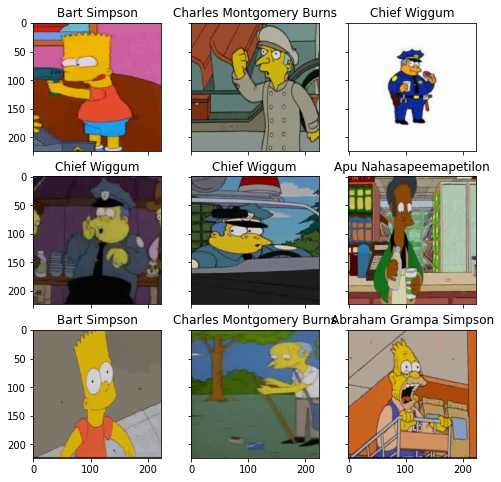

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Функции для тренировки сети


In [23]:
def fit_epoch(model, train_loader, criterion, optimizer):
    # initialize tracked variables
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # reset the gradient
        optimizer.zero_grad()
        
        # predictions (probabilities), loss, backprop
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # weights update
        optimizer.step()
        
        # predictions (classes)
        preds = torch.argmax(outputs, 1)
        
        # record tracked items
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        
    # record train loss and train accuracy          
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [24]:
def eval_epoch(model, val_loader, criterion):
    # set model model into the evaluation mode (e.g. for Dropout)
    model.eval()
    
    # initialize tracked variables
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
        
        # record tracked items
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        
    # record val loss and val accuracy
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [25]:
def train(train_dataset, val_dataset, model, criterion,
          epochs, batch_size, optimizer, scheduler,
          shuffle=True, sampler=None, patience=5):
    
    # to record the total training time
    since = time.time()
    
    # note: 4 workers loading the data
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, sampler=sampler, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # init variables to store best model weights, best accuracy, best epoch number, epochs since best accuracy acheived
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10
    best_epoch = 0
    epochs_since_best = 0
    
    # history and log
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(1, epochs+1):
            print(f"epoch {epoch}:\n")
            
            print("Fitting on train data...")
            # all arguments except train loader are from parameters passed to train() arguments
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("train loss:", train_loss)
            
            print("Evaluating on validation data...")
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            print("val loss:", val_loss)
            
            # record history
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            # update learning rate for the optimizer
            scheduler.step()
            
            # display learning status
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            # deep copy the model if it acheives the best validation performance
            if val_loss < best_loss:
                best_acc = val_loss
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
                print()
            else:
                epochs_since_best += 1
            
            # early stopping
            if epochs_since_best > patience:
                print(f'Stopping training. The validation metric has not improved for {patience} epochs.')
                break
            
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))
    print('Best epoch: {}'.format(best_epoch))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
            
    return history

In [26]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

### Тренируем только последний слой сети

In [27]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16031 sha256=7e4fe0e591fc6851d0f0fcd47910284c19a15e803a7f32fc1d3a805230e1d5c2
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [28]:
from efficientnet_pytorch import EfficientNet

In [29]:
model_name = 'efficientnet-b2'

In [30]:
model = EfficientNet.from_pretrained(model_name)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth



Loaded pretrained weights for efficientnet-b2


In [31]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [32]:
for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, N_CLASSES)

# to GPU
model = model.to(DEVICE)

# loss
criterion = nn.CrossEntropyLoss()

# learning rate optimizer
optimizer = torch.optim.AdamW(model.parameters())

# scheduler for the lr optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, 0.5)

In [33]:
model._fc

Linear(in_features=1408, out_features=42, bias=True)

In [34]:
# feature_extr_epochs = 1 # test run
feature_extr_epochs = 5 # performance run

In [35]:
history_feature_extr = train(train_dataset, val_dataset, model=model, criterion=criterion,
                             epochs=feature_extr_epochs, batch_size=256, optimizer=optimizer, scheduler=scheduler)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

epoch 1:

Fitting on train data...
train loss: 2.7967385551962
Evaluating on validation data...


epoch:  20%|██        | 1/5 [03:38<14:33, 218.30s/it]

val loss: 2.4756865210996652

Epoch 001 train_loss: 2.7967     val_loss 2.4757 train_acc 0.3339 val_acc 0.4402

epoch 2:

Fitting on train data...
train loss: 1.9789676396965687
Evaluating on validation data...


epoch:  40%|████      | 2/5 [07:15<10:53, 217.91s/it]

val loss: 1.7165832539461152

Epoch 002 train_loss: 1.9790     val_loss 1.7166 train_acc 0.5623 val_acc 0.6274

epoch 3:

Fitting on train data...
train loss: 1.5327676245894801
Evaluating on validation data...


epoch:  60%|██████    | 3/5 [10:56<07:17, 218.75s/it]

val loss: 1.4464469699094311

Epoch 003 train_loss: 1.5328     val_loss 1.4464 train_acc 0.6405 val_acc 0.6742

epoch 4:

Fitting on train data...
train loss: 1.3563814569548776
Evaluating on validation data...


epoch:  80%|████████  | 4/5 [14:35<03:39, 219.08s/it]

val loss: 1.3642601476012877

Epoch 004 train_loss: 1.3564     val_loss 1.3643 train_acc 0.6762 val_acc 0.6869

epoch 5:

Fitting on train data...
train loss: 1.2748973303741322
Evaluating on validation data...


epoch: 100%|██████████| 5/5 [18:16<00:00, 219.22s/it]

val loss: 1.297978401468795

Epoch 005 train_loss: 1.2749     val_loss 1.2980 train_acc 0.6907 val_acc 0.6993

Training complete in 18m 16s
Best val loss: 10.000000
Best epoch: 5


Построим кривые обучения

In [36]:
loss, acc, val_loss, val_acc = zip(*history_feature_extr)

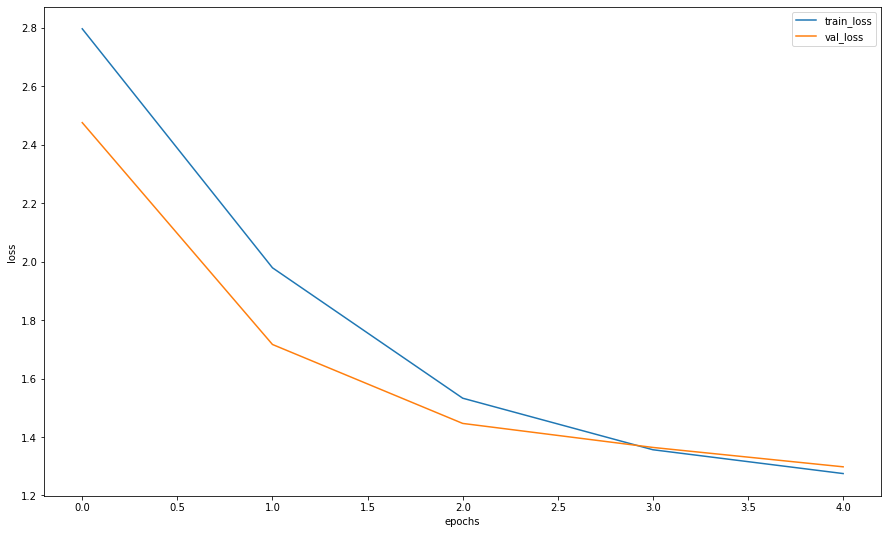

In [37]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Тренируем все слои сети

In [38]:
for param in model.parameters():
    param.requires_grad = True

In [39]:
# finetuning_epochs = 1 # test run
finetuning_epochs = 15 # performance run

In [40]:
history_fine_tune = train(train_dataset=train_dataset, val_dataset=val_dataset, model=model, criterion=criterion,
                          epochs=finetuning_epochs, batch_size=64, optimizer=optimizer, scheduler=scheduler)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

epoch 1:

Fitting on train data...
train loss: 0.35643348333933456
Evaluating on validation data...


epoch:   7%|▋         | 1/15 [07:22<1:43:12, 442.30s/it]

val loss: 0.17322989011012999

Epoch 001 train_loss: 0.3564     val_loss 0.1732 train_acc 0.9062 val_acc 0.9575

epoch 2:

Fitting on train data...
train loss: 0.08512868887066401
Evaluating on validation data...


epoch:  13%|█▎        | 2/15 [14:44<1:35:48, 442.21s/it]

val loss: 0.12804103522677823

Epoch 002 train_loss: 0.0851     val_loss 0.1280 train_acc 0.9784 val_acc 0.9678

epoch 3:

Fitting on train data...
train loss: 0.057929131542141875
Evaluating on validation data...


epoch:  20%|██        | 3/15 [22:06<1:28:26, 442.23s/it]

val loss: 0.12429919949409528

Epoch 003 train_loss: 0.0579     val_loss 0.1243 train_acc 0.9861 val_acc 0.9725

epoch 4:

Fitting on train data...
train loss: 0.03782579450755795
Evaluating on validation data...


epoch:  27%|██▋       | 4/15 [29:28<1:21:04, 442.25s/it]

val loss: 0.13293134766013134

Epoch 004 train_loss: 0.0378     val_loss 0.1329 train_acc 0.9892 val_acc 0.9701

epoch 5:

Fitting on train data...
train loss: 0.015102485562001363
Evaluating on validation data...


epoch:  33%|███▎      | 5/15 [36:51<1:13:42, 442.28s/it]

val loss: 0.10854844581749507

Epoch 005 train_loss: 0.0151     val_loss 0.1085 train_acc 0.9959 val_acc 0.9792

epoch 6:

Fitting on train data...
train loss: 0.009279073929172313
Evaluating on validation data...


epoch:  40%|████      | 6/15 [44:13<1:06:19, 442.13s/it]

val loss: 0.10706306140623402

Epoch 006 train_loss: 0.0093     val_loss 0.1071 train_acc 0.9974 val_acc 0.9830

epoch 7:

Fitting on train data...
train loss: 0.0062956163417282485
Evaluating on validation data...


epoch:  47%|████▋     | 7/15 [51:34<58:55, 441.91s/it]

val loss: 0.11663408884125781

Epoch 007 train_loss: 0.0063     val_loss 0.1166 train_acc 0.9980 val_acc 0.9826

epoch 8:

Fitting on train data...
train loss: 0.005218786438859095
Evaluating on validation data...


epoch:  53%|█████▎    | 8/15 [58:58<51:37, 442.50s/it]

val loss: 0.11854823664169577

Epoch 008 train_loss: 0.0052     val_loss 0.1185 train_acc 0.9983 val_acc 0.9835

epoch 9:

Fitting on train data...
train loss: 0.0030786064233403014
Evaluating on validation data...


epoch:  60%|██████    | 9/15 [1:06:22<44:17, 442.96s/it]

val loss: 0.11796792255210894

Epoch 009 train_loss: 0.0031     val_loss 0.1180 train_acc 0.9994 val_acc 0.9826

epoch 10:

Fitting on train data...
train loss: 0.001990109160894455
Evaluating on validation data...


epoch:  67%|██████▋   | 10/15 [1:13:47<36:57, 443.60s/it]

val loss: 0.1280293590686695

Epoch 010 train_loss: 0.0020     val_loss 0.1280 train_acc 0.9994 val_acc 0.9826

epoch 11:

Fitting on train data...
train loss: 0.0016433709118035909
Evaluating on validation data...


epoch:  73%|███████▎  | 11/15 [1:21:13<29:36, 444.22s/it]

val loss: 0.11990588904974417

Epoch 011 train_loss: 0.0016     val_loss 0.1199 train_acc 0.9995 val_acc 0.9842

epoch 12:

Fitting on train data...
train loss: 0.0013022593160653053
Evaluating on validation data...


epoch:  80%|████████  | 12/15 [1:28:37<22:12, 444.32s/it]

val loss: 0.118093865692435

Epoch 012 train_loss: 0.0013     val_loss 0.1181 train_acc 0.9995 val_acc 0.9840

epoch 13:

Fitting on train data...
train loss: 0.0016854263127656789
Evaluating on validation data...


epoch:  87%|████████▋ | 13/15 [1:36:02<14:49, 444.53s/it]

val loss: 0.1281294782729913

Epoch 013 train_loss: 0.0017     val_loss 0.1281 train_acc 0.9993 val_acc 0.9823

epoch 14:

Fitting on train data...
train loss: 0.0013546139436647435
Evaluating on validation data...


epoch:  93%|█████████▎| 14/15 [1:43:27<07:24, 444.54s/it]

val loss: 0.11727093156193842

Epoch 014 train_loss: 0.0014     val_loss 0.1173 train_acc 0.9996 val_acc 0.9852

epoch 15:

Fitting on train data...
train loss: 0.0013362383001859677
Evaluating on validation data...


epoch: 100%|██████████| 15/15 [1:50:51<00:00, 443.45s/it]

val loss: 0.11529863828859119

Epoch 015 train_loss: 0.0013     val_loss 0.1153 train_acc 0.9996 val_acc 0.9845

Training complete in 110m 52s
Best val loss: 10.000000
Best epoch: 15


Построим кривые обучения

In [41]:
loss, acc, val_loss, val_acc = zip(*history_fine_tune)

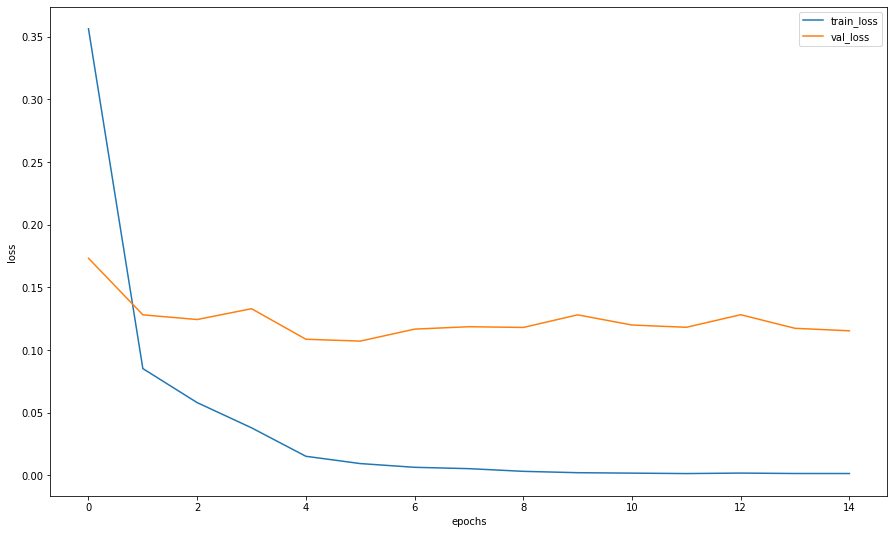

In [42]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")


plt.savefig(f"{model_name}_{feature_extr_epochs}FeatureExtrEpochs-{finetuning_epochs}FinetuningEpochs-LearningCurve.png")
plt.show()

In [43]:
f"{model_name}_{feature_extr_epochs}FeatureExtrEpochs-{finetuning_epochs}FinetuningEpochs-LearningCurve.png"

'efficientnet-b2_5FeatureExtrEpochs-15FinetuningEpochs-LearningCurve.png'

In [44]:
# save the weights of our net
model_weights = copy.deepcopy(model.state_dict())
torch.save(model_weights, f"{model_name}_{feature_extr_epochs}FeatureExtrEpochs-{finetuning_epochs}FinetuningEpochs-weights.pth")

In [45]:
%ls

efficientnet-b2_5FeatureExtrEpochs-15FinetuningEpochs-LearningCurve.png
efficientnet-b2_5FeatureExtrEpochs-15FinetuningEpochs-weights.pth
gdrive/
label_encoder.pkl
sample_data/
test/
train/


In [46]:
# загружаем сохраненное состояние весов нейросети
model.load_state_dict(torch.load(f"{model_name}_{feature_extr_epochs}FeatureExtrEpochs-{finetuning_epochs}FinetuningEpochs-weights.pth"))

<All keys matched successfully>

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [47]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [48]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [49]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

### Сравниваем фактические классы с предсказанными ids

In [50]:
actual_labels = [val_dataset[id][1] for id in idxs]
actual_labels

[4, 4, 6, 2, 2, 7, 2, 6, 6, 0, 2, 6, 7, 2, 6, 2, 4, 6, 0, 0]

In [51]:
y_pred = np.argmax(probs_ims, -1)
y_pred

array([4, 4, 6, 2, 2, 7, 2, 6, 6, 0, 2, 6, 7, 2, 6, 2, 4, 6, 0, 0])

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [52]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='weighted')

1.0

## Сравниваем фактические классы с предсказанными (strings)

In [53]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [54]:
actual_class = [label_encoder.classes_[i] for i in actual_labels]
actual_class

['bart_simpson',
 'bart_simpson',
 'charles_montgomery_burns',
 'apu_nahasapeemapetilon',
 'apu_nahasapeemapetilon',
 'chief_wiggum',
 'apu_nahasapeemapetilon',
 'charles_montgomery_burns',
 'charles_montgomery_burns',
 'abraham_grampa_simpson',
 'apu_nahasapeemapetilon',
 'charles_montgomery_burns',
 'chief_wiggum',
 'apu_nahasapeemapetilon',
 'charles_montgomery_burns',
 'apu_nahasapeemapetilon',
 'bart_simpson',
 'charles_montgomery_burns',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson']

In [55]:
preds_class = [label_encoder.classes_[i] for i in y_pred]
preds_class

['bart_simpson',
 'bart_simpson',
 'charles_montgomery_burns',
 'apu_nahasapeemapetilon',
 'apu_nahasapeemapetilon',
 'chief_wiggum',
 'apu_nahasapeemapetilon',
 'charles_montgomery_burns',
 'charles_montgomery_burns',
 'abraham_grampa_simpson',
 'apu_nahasapeemapetilon',
 'charles_montgomery_burns',
 'chief_wiggum',
 'apu_nahasapeemapetilon',
 'charles_montgomery_burns',
 'apu_nahasapeemapetilon',
 'bart_simpson',
 'charles_montgomery_burns',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson']

In [56]:
from sklearn.metrics import f1_score

f1_score(actual_class, preds_class, average='weighted')

1.0

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

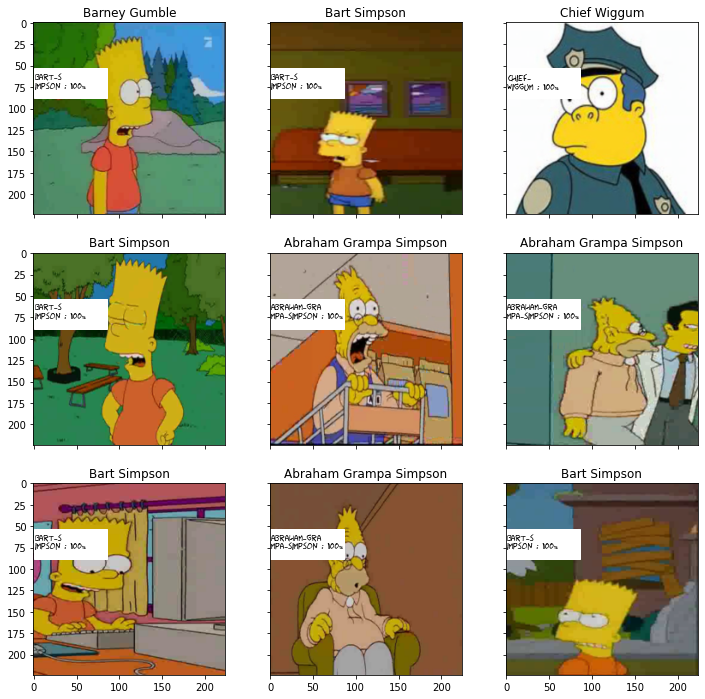

In [57]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [58]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64, num_workers=4)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [59]:
import pandas as pd
sample_submit = pd.read_csv("gdrive/MyDrive/Simpsons_kaggle/sample_submission.csv")
sample_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [60]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
print(my_submit.shape)
my_submit.head()

(991, 2)


,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [61]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [62]:
path = 'gdrive/MyDrive/Simpsons_kaggle/'
my_submit.to_csv(path + f"{model_name}_{feature_extr_epochs}FeatureExtrEpochs-{finetuning_epochs}FinetuningEpochs-submission.csv")

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
